## 2.2. <a id='toc2_2_'></a>[Environment Setup](#toc0_)

The environment setup for the Thymio includes the goal, static obstacles, background and thymio covering. The choices we made for the setup are highly related to the vision part as we have to be able to process the image captured. We decided the static obstacles would be in 2D to avoid shadows, that way they are easier to detect with the camera. The obstacles are black on a lighter background (ideally white but it would work with any light color). Our obstacles have to be shapes with sharp lines and edges, they cannot be curvilinear. We are using a red square goal and two points (green in the middle and blue on the front)on the robot. Those are the features of our environment. The setup has no boundary points and extend to the full viewing angle of the camera, so that the full picture detected can be exploited. 

A further explanation on how those obstacles and features are detected is given in the computer vision part. 

Below is an example of a frame captured by the camera were the different features mentionned are visible : 

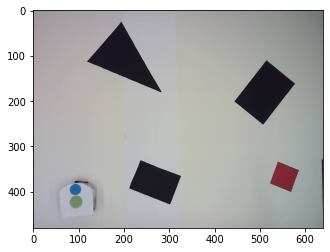

## 3.1. <a id='toc3_4_'></a>[Computer Vision](#toc0_)

<u>**Idea**</u>

The **Vision** module is mostly based on the OpenCV documentation. Other sources used are mentionned throughout the explanation. 
The purpose of the computer vision part, which is autonomous from the other parts but is essential to compute the reference points of the setup, is to capture and use the picture from the camera to extract the main features of the environment, analyze them and give the needed infos to the global navigation and odometry modules (i.e. actual robot position and angle, goal position and obstacles positions). The particularity of the Computer Vision module is that it does not communicate with the robot. 

The selected approach is based on color, shape and corners recognition. We began with "perfect" pictures of setup created virtually and had to rescale quite a bit the values once we switched to the "noisy" pictures of the camera.

As for the code implemented, we created a vision class containing the basic arguments needed and computed by vision and the functions that just have to be called in the main when needed. Some vision infos need to be recomputed each time, such as the robot position and angle, and some of them need only be computed at first step, like the obstacles position and corners that will not move during execution. 



**1. Image capturing and filtering**

At first, a frame is extracted from the camera. The camera has already been activated in the main (video registered in cap). Note that we capture two frames because we noticed sometimes, at first connection of the camera to the computer, the first frame captured was "yellowish" and too bright to be used. We then filter the image several times to avoid noise and have a "smooth" picture to perform the other steps on. 

For the filtering, we tested several combinations and the one in the code below seemed to be the one that worked best. We therefore performs 2D linear filtering, then we blur the frame and then apply an additional median blur. Our filtered frame is registered in the vision Class to be used by all other vision functions. 

In [ ]:
def capture_image(self,cap): 
        #capture a frame out of the video that will be used through CV part 
        ret, self.frame = cap.read()
        ret, self.frame = cap.read()
        kernel = np.ones((5,5),np.float32)/25
        img = cv2.filter2D(self.frame,-1,kernel)
        img = cv2.blur(img,(5,5))
        self.img = cv2.medianBlur(img,5)


**2. Goal position, thymio position and angle tracking**

To find the coordinates of the goal and start position, we use color filtering. We apply a color mask of the target color (red for the goal, blue and green for the robot) on the picture and then use maxLoc function or contour finding to extract the coordinates. The values of the color mask have been found using hsv color space graph and forums, they are empiric values adapted to our setup, and to the colors of the papers we are using. Indeed, one of the main "flaws" of the vision part, that will be discussed more in details in the weakness part, is that it is quite sensitive to light and color changes and uniformity.

The function find_goal_pos applies a red mask to the filtered frame, isolating the goal shape. Then we apply a contour detection on the thresholded image and find the moment, i.e. center of the shape. This value corresponds to the goal position (center of the red square). 

The functions find_start_pos and find_angle provide the coordinates of the two points on top of the thymio. As the circle is of small radius, we use maxLoc function to compute the coordinates, so it is not the exact center of the point but it is precise enough (more or less 10points on a grid of 480x640). The green point is used as starting point, i.e. as the position of the thymio. The blue one is used to compute the angle of the thymio. We obtain a positive angle going from zero to two py starting from the x axis and turning counterclockwise. We made several measures for the odometry part comparing measured value and real values, and the precision of the angle is +-0.01rad. 

At the end of the functions computing the positions and angle, we store those values in the shared Thymio Class to be used by the other functions of the code.

The *find_angle* function pasted below computes the coordinates of the blue point on the thymio at first in the same way the coordinates of the green (=start point) are computed. Then, using both green (back) and blue (front) coordinates, we compute the angle. 

Below is the thresholded image of the frame given as example with red mask applied, and of the green point on the robot, along with the coordinates computed by the functions. 

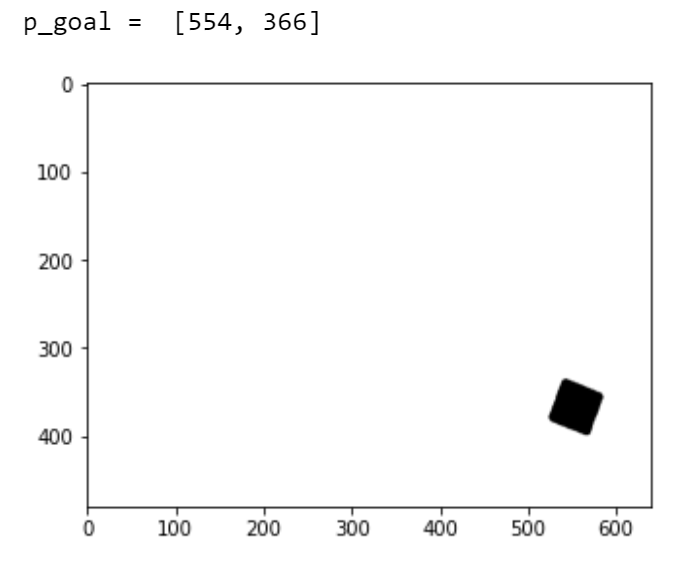

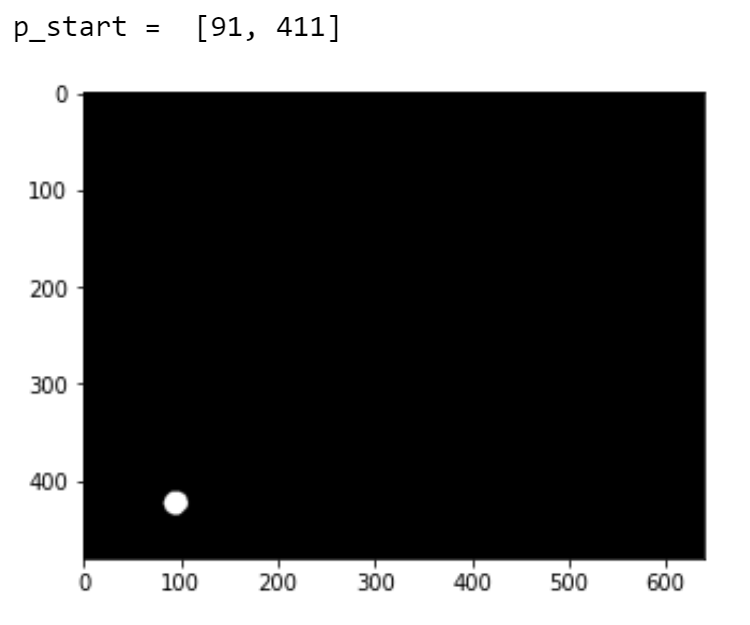

In [1]:
def find_angle(self,robot):
        # COORDINATES OF THE BLUE POINT 
        hsv = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, self.LOW_BLUE, self.HIGH_BLUE)
        blue = cv2.bitwise_and(self.frame,self.frame, mask = mask)
        gray = cv2.cvtColor(blue, cv2.COLOR_RGB2GRAY) 
        _, self.thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY) 
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(self.thresh1)
        [x_front,y_front] = maxLoc
        # WE VERIFY ONE BLUE POINT IS ACTUALLY DETECTED TO AVOIR HIDING SITUATIONS (if the robot is hidden, we do not
        # recompute the coordinates)
        if (x_front != 0) or (y_front != 0):
            [self.x_front,self.y_front] = [x_front,y_front]
        # ANGLE COMPUTATION
            if self.y_front < self.y_back : 
                if self.x_front > self.x_back : 
                    self.teta = np.arccos((self.x_front-self.x_back)/(np.sqrt(np.power((self.x_front-self.x_back),2)+np.power((self.y_front-self.y_back),2))))
                if self.x_front <= self.x_back : 
                    self.teta = np.pi - np.arccos((self.x_back-self.x_front)/(np.sqrt(np.power((self.x_front-self.x_back),2)+np.power((self.y_front-self.y_back),2))))
            if self.y_front >= self.y_back : 
                if self.x_front > self.x_back : 
                    self.teta = 2*np.pi - np.arccos((self.x_front-self.x_back)/(np.sqrt(np.power((self.x_front-self.x_back),2)+np.power((self.y_front-self.y_back),2))))
                if self.x_front <= self.x_back : 
                    self.teta = np.pi + np.arccos((self.x_back-self.x_front)/(np.sqrt(np.power((self.x_front-self.x_back),2)+np.power((self.y_front-self.y_back),2))))
        # PASS THE VARIABLES TO THE SHARED THYMIO CLASS AND INDICATE THAT VISION IS DONE
            robot.setPositions(self.x_back,self.y_back,self.x_goal,self.y_goal,self.teta)
            robot.setVisionDone(True)
        # If hidden thymio, do not update the vision variables 
        else:
            robot.setVisionDone(False)


**3. Obstacles**

For the obstacles identification part, it depends on the type of global navigation used. As discussed in the next *Gloabl Navigation* section, we implemented two methods for global part, Astar and Visibility.  

In the case of visibility graph, the process used is the following:  
At first, we apply a big thresholding on the gray image to obtain a frame containing only the obstacles (for a noisy image, we set an empirical value of 40, which keeps only the black obstacles). The corners and moments of the obstacles are obtained using openCV corners and moments finding functions. We then implemented a small part of code placing the corners further away from the shapes to avoid the thymio running into the obstacles when following the side of a shape. The value of the distance of the corners to their shape is a variable that can be changed in the code, and that should typically be half the size of the thymio. We also took out the corners too close to the borders as we do not want the thymio to go outside the setup boundaries. Those methods are implememted in the function *find_corners*.  

Then we have to provide the *global navigation* part a "visibility graph" with the nodes and weights of each node to all others. Obviously the nodes considered are the corners plus start and goal position. We therefore compute a matrix containing the distance of each point to all others, implemented in the *compute_dist_mx* function. But we cannot just calculate the distance between points because if there is an obstacle in the way between two points, it must not be taken into account. We therefore decided to use threshold on the line to avoid this. Here is a quick explanation of the approach: on the thresholded image of the obstacles, if we extract the pixel values of the line between two points, if it contains black, there is an obstacle in the way and we do not compute the distance. 

To optimally use this 'line threshold' technique, and before calling compute_dist_mx function, we call the function *trace_contours* that traces the lines beteween the corners to avoid computing path in the "forbidden area" between obstacles and corners. 

Below is a picture of the frame used for this setup to compute the distance matrix, and an example of a distance matrix obtained for the setup provided as illustration. Distance_matrix should be read as follow: indices along vertical and horizontal dimensions are [start_point, corner1, corner2, ..., cornerN, goal_point], matrix_element[i,j] = distance between corner[i] and corner[j], and if there is an obstacle in the path, distance = 0. 

In [ ]:
def find_corners(self):
        # Put the filtered image in grayscale
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY) 
        # Threshold the image to keep only black elements
        ret, thresh2 = cv2.threshold(gray, self.BLACK_THRESHOLD, 255, cv2.THRESH_BINARY) 
        # Find contours of obstacles 
        contours, _ = cv2.findContours( 
            thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
        self.thresh2 = thresh2
        i = 0
        m = []
        # Find moments, i.e. centers of obstacles 
        for contour in contours:  
            if i == 0: 
                i = 1
                continue
            M = cv2.moments(contour) 
            if M['m00'] != 0.0: 
                x = int(M['m10']/M['m00']) 
                y = int(M['m01']/M['m00']) 
                if len(m)<self.NB_SHAPES:
                    m.append([x,y])
        th3 = cv2.adaptiveThreshold(self.thresh2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                    cv2.THRESH_BINARY,11,2)
        # Find corners of obstacles 
        corners = cv2.goodFeaturesToTrack(th3, self.NB_CORNERS, 0.01, 45) 
        corners = np.int0(corners) 
        # Part of code that changes the coordinates of the corners to put them away from the obstacles 
        *** CODE TO PUT THE CORNERS AWAY FROM THE OBSTACLES ***

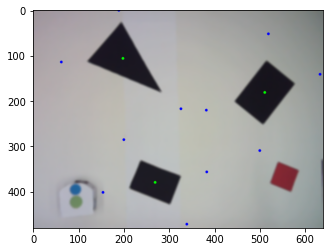

In [ ]:
def trace_contours(self):
        a = int(np.size(self.cornerss)/2)
        b = int(np.size(self.m_cor)/2)
        for i in range (0,a):
            for j in range (0,b):
                if i != j:
                    if self.m_cor[i] == self.m_cor[j]:
                        line = np.transpose(np.array(draw.line(self.cornerss[i][0], self.cornerss[i][1], self.cornerss[j][0], self.cornerss[j][1])))
                        data = self.thresh2[line[:, 1], line[:, 0]]
                        if np.size(np.where(abs(np.diff(data))>0)[0]) <= 2:
                            if np.mean(data) > self.mean_value_along_line:
                                cv2.line(self.thresh2, self.cornerss[i], self.cornerss[j], self.bluepx, 4)

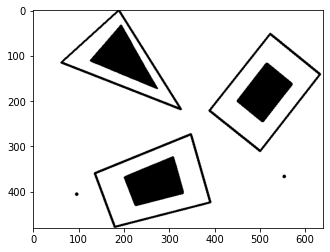

In [ ]:
def compute_dist_mx(self,robot):
        s = int(((np.size(self.cor))/2)+2) 
        dist_mx = np.zeros((s,s))
        for i in range(1,s):
            if i == (s-1):
                line = np.transpose(np.array(draw.line(self.x_back,self.y_back, self.x_goal,self.y_goal)))
                data = self.thresh2[line[:, 1], line[:, 0]]
                if np.size(np.where(abs(np.diff(data))>0)[0]) <= 3 : 
                    dist_mx[i][0] = np.sqrt(np.power((self.x_goal-self.x_back),2)+np.power((self.y_goal-self.y_back),2))
                continue 
            line = np.transpose(np.array(draw.line(self.x_back,self.y_back,self.cor[i-1][0],self.cor[i-1][1])))
            data = self.thresh2[line[:, 1], line[:, 0]]
            if np.size(np.where(abs(np.diff(data))>0)[0]) <= 3 : 
                dist_mx[i][0] = np.sqrt(np.power((self.cor[i-1][0]-self.x_back),2)+np.power((self.cor[i-1][1]-self.y_back),2))
        for i in range(0,(s-2)):
            for j in range(0,s):
                if j == (i+1):
                    continue 
                if j == 0 : 
                    line = np.transpose(np.array(draw.line(self.x_back,self.y_back, self.cor[i][0],self.cor[i][1])))
                    data = self.thresh2[line[:, 1], line[:, 0]]
                    if np.size(np.where(abs(np.diff(data))>0)[0]) <= 3 : 
                        dist_mx[j][i+1] = np.sqrt(np.power((self.cor[i][0]-self.x_back),2)+np.power((self.cor[i][1]-self.y_back),2))
                    continue 
                if j == int(s-1):
                    line = np.transpose(np.array(draw.line(self.x_goal,self.y_goal, self.cor[i][0],self.cor[i][1])))
                    data = self.thresh2[line[:, 1], line[:, 0]]
                    if np.size(np.where(abs(np.diff(data))>0)[0]) <= 3 : 
                        dist_mx[j][i+1] = np.sqrt(np.power((self.cor[i][0]-self.x_goal),2)+np.power((self.cor[i][1]-self.y_goal),2))
                    continue
                line = np.transpose(np.array(draw.line(self.cor[j-1][0],self.cor[j-1][1],self.cor[i][0],self.cor[i][1])))
                data = self.thresh2[line[:, 1], line[:, 0]]
                if np.size(np.where(abs(np.diff(data))>0)[0]) <= 3 : 
                    dist_mx[j][i+1] = np.sqrt(np.power((self.cor[i][0]-self.cor[j-1][0]),2)+np.power((self.cor[i][1]-self.cor[j-1][1]),2))
        for i in range(0,(s-1)):
            if i == 0:
                line = np.transpose(np.array(draw.line(self.x_back,self.y_back, self.x_goal,self.y_goal)))
                data = self.thresh2[line[:, 1], line[:, 0]]
                if np.size(np.where(abs(np.diff(data))>0)[0]) <= 3 : 
                    dist_mx[0][s-1] = np.sqrt(np.power((self.x_goal-self.x_back),2)+np.power((self.y_goal-self.y_back),2))
                continue 
            line = np.transpose(np.array(draw.line(self.x_goal,self.y_goal,self.cor[i-1][0],self.cor[i-1][1])))
            data = self.thresh2[line[:, 1], line[:, 0]]
            if np.size(np.where(abs(np.diff(data))>0)[0]) <= 3 : 
                dist_mx[i][s-1] = np.sqrt(np.power((self.cor[i-1][0]-self.x_goal),2)+np.power((self.cor[i-1][1]-self.y_goal),2))
        self.dist_mx = dist_mx
        robot.setDistMx(dist_mx)
        robot.setCor(self.cor)
        robot.setS(s)

Example of a distance matrix

Concerning the vision work for the Astar algorithm, we provide the global navigation part an occupancy matrix, containing 0 where the space is free and 1 where there is an obstacle. We first need to resize the image because Astar needs a smaller grid to operate quickly enough. We can set the resizing parameters in the code.  

We use the obstacle image and transform it into a matrix, and then apply a threshold on the values of the matrix to obtain a binary 0/1 matrix, and store the occupancy matrix in the shared robot Class instance. This is implemented in the function *return_occupancy_matrix*. 

In [ ]:
def return_occupancy_matrix(self,robot):
        dim = (self.width_resized, self.height_resized)
        img = cv2.resize(self.img, dim, interpolation = cv2.INTER_AREA)
        rszd = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mtx = np.array(rszd)
        mx = (mtx < 20).astype(int)
        robot.occupancy_matrix = mx

**Discussion of the flaws of the computer vision part**

- The color filtering is fun and useful but with hsv space and masking, we explore a "range" of values (for example "reddish" values). In noisy pictures, if the range is too large, we will detect a little bit of this color somewhere it should not be, and on the contrary if the range is too small we will not detect the target, or we will detect it in one lightning condition and not the other. To have an optimal color detection, we should have "perfect" pictures which, in reality, do not exist. It is therefore an issue to be dealt with. In our case, once the picture was well filtered and the mask were adapted to the colors we used, it worked well in most situations. 

- The functions implementing the distance matrix, putting away corners and thresholding along lines have been computed fully "by hand" and are surely not optimized. Using existing libraries and tools, we could optimize those functions and clean them out.

- The visibility part is very sensitive to lightning conditions.

- Our setup and code would not work with faded colors, bright light spot somewhere on the frame, artificial colored light or unidentified obstacles.

- Our approach does not support round shaped obstacles.

- The algorithm needs to be provided the exact number of shapes and corners before the execution. Those variables can be easily modified in the code. 

**Implementation of Vision in the main**

At the beginning of the execution, a new instance of *vision Class* is created, along with a capture of the video taken by the camera. In the infinity loop, the vision functions are always called first as those values are needed for the rest of the program. It is implememted as follows:

- vision Class instance initialized outside the while loop at the beginning of the execution.

- initialization of the video captured from the camera.

In the infinity loop:  
- Every time, we capture a new frame, find the goal and thymio position and angle. 

- We only compute the contours and corners of the obstacles once.

- The distance matrix for the visibility graph (+ path recomputing discussed in the global navigation part) is computed the first time we execute the loop, plus everytime we are in a kidnapping situation. 

In [ ]:
#Classes initialization
robot=Thymio() # Set Thym as class Thymio as initialization before the while
KF = KalmanFilter()
vision = Vision()
global_nav = Global_Nav()

#Video capturing 
cap = cv2.VideoCapture(1)

a = 0
while(1) :
    a = a + 1
    #VISION
    vision.capture_image(cap)
    vision.find_goal_pos()
    vision.find_start_pos(robot,a)
    vision.find_angle(robot)
    if (a == 1) : 
        vision.find_corners()
        vision.trace_contours()
    if ((robot.vision == 1) & (a == 1))or((a != 1) & (robot.kidnap == True) & (robot.vision == 1)):
        vision.compute_dist_mx(robot)
        global_nav.dijkstra(robot)
        global_nav.extract_path(robot)
        if robot.kidnap == True:
            robot.kidnap = False
    robot.vision = True
    #END VISION 
    ***REST OF THE CODE***

**Sources :**

TP2 and 'Project Computer Vision tutorial' of the *Basics of mobile robotic* course  
OpenCV documentation: https://docs.opencv.org/4.x/  
https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/  
https://www.geeksforgeeks.org/python-detect-corner-of-an-image-using-opencv/  
https://stackoverflow.com/questions/30331944/finding-red-color-in-image-using-python-opencv  
https://www.delftstack.com/fr/howto/python/opencv-inrange/   

## 3.2. <a id='toc3_2_'></a>[Global Navigation](#toc0_)

<u>**Idea**</u>

The **Global Navigation** module goal is to provide a path for the *motion control* module, based on the informations provided by the *vision* module. We implemented two different global navigation methods that both ended working, but do not use the same setup and variables. First, an explanation about visibility graph method will be given. We use the distance matrix between the points provided in the robot class instance and compute the best path using Dijkstra's algorithm in the function *dijkstra*, based on the pseudo-code we found here: https://www.baeldung.com/cs/dijkstra#:~:text=Dijkstra's%20Algorithm%20is%20a%20pathfinding,we%20reach%20the%20end%20node.  

The output of this function is a *graph* matrix containing, for each node, its state ('visited' or not), its score to the start point and, most importantly, its nearest node (to the start).


In [ ]:
def dijkstra(self,robot):

        self.dist_mx = robot.getDistMx()
        self.s = robot.getS()
        graph = np.zeros((3,self.s))
        graph[0] = 3000 
        graph[0][0] = 0
        graph[2] = 42
        result = 0
        current_node = 0
        a = 0
        while 1:
            b = 0
            for i in range (0,self.s):
                if graph[1][i] == 0: 
                    b = b + 1
                    if graph[0][i] < graph[0][result]:
                        result = i
                    if b == 1:
                        result = i
            current_node = result 
            graph[1][current_node] = 1
            for i in range (0,self.s):
                if self.dist_mx[i][current_node] != 0:
                    if graph[1][i] == 0: 
                        new_score = graph[0][current_node] + self.dist_mx[i][current_node]
                        if new_score < graph[0][i]:
                            graph[0][i] = new_score 
                            graph[2][i] = current_node 
            if current_node == int(self.s-1):
                break
            for i in range (0,self.s):
                if graph[1][i] == 0: 
                    if graph[0][i] < graph[0][result]:
                        result = i
                        if graph[0][result] == 3000:
                            break

        self.graph = graph 
        self.current_node = current_node 

We then use the function *extract_path* to compute in a single array the coordinates of the path points, from start point (thymio) to goal. This is done by extracting the coordinates using *graph* matrix, going from goal through each 'closest node' until start position. We then put this path in the shared robot class to be used by *motion control* module.  

Below is an example of a path computed by the Visibility Graph algorithm.  

In [ ]:
def extract_path(self,robot):
        cor = robot.getCor()
        path = [self.current_node]
        node = self.current_node
        while node != 0:
            path.append(int(self.graph[2][node]))
            node = path[-1]
        path = np.flip(path)
        path_coord = [[robot.pos_X,robot.pos_Y]]
        a = 0
        for p in path : 
            a = a + 1 
            if a != 1:
                if a != np.size(path):
                    i = int(p-1)
                    path_coord.append(cor[i])
        path_coord.append([robot.goal_X,robot.goal_Y])
        robot.path = path_coord
        if len(path_coord)>1:
            robot.setAngle()
        self.path = path 
        self.path_coord = path_coord

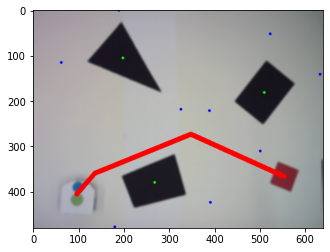

Let us now discuss the *Global Navigation* algorithms for Astar method, using the occupancy_matrix provided by the *vision part*.  

BLABLA

**Discussion of the differences between Astar and Visibility**

- The Astar computes a more 'optimal' path than Visibility but is way slower for a big grid. The disadvantage is therefore that we have to resize the frame to a lower scale, loosing resolution, and therefore having to put only big square obstacles on defined emplacements.  

- The Visibility Graph forces us to navigate between points and most of the time to follow obstacles contours. But it is way faster than Astar, even on big grids, which allows us to use almost any shape and range of size for the obstacles.  

To use both methods, we therefore have to change the setup between testings.  